In [4]:
import json
import pandas as pd
import numpy as np
import pickle
from nltk.metrics import agreement
from nltk.metrics.agreement import AnnotationTask
from nltk.metrics import masi_distance, jaccard_distance
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from joblib import Parallel, delayed

In [6]:
# Load the set of texts that every annotator labeled
agreement_set = pd.read_pickle('agreement_set.pkl')

In [8]:
agreement_set.head(2)

,danique,julian,jasper,fabrice,max,anita,connie,eva,imke,jan,joey,nina,ruud,walter,lino,stijn
text,,,,,,,,,,,,,,,,
Heel erg slecht bestelling naar belgie in de plaats naar nederland heel erg slordig,[Boosheid (woede)],[Walging],[Walging],"[Boosheid (woede), Walging]",[Boosheid (woede)],[Geen Emoti],[Boosheid (woede)],[Vreugde],[Boosheid (woede)],[Boosheid (woede)],"[Anticipatie, Niet Bruikbaar]",[Boosheid (woede)],[Boosheid (woede)],[Vreugde],"[Boosheid (woede), Niet Bruikbaar]",[Boosheid (woede)]
Als het mogelijk was. Had ik liever minder dan 1 ster gegeven. Pakket is gewoon in de voortuin gelegd. Heb op de beveiligingscamera kunnen zien dat de bezorger niet eens de moeite neemt om bij de buren na te vragen of iets dergelijks. Dit is echt de meest belachelijke en asosiale bezorg service die ik ooit gehad hebt.,[Boosheid (woede)],"[Boosheid (woede), Walging]","[Boosheid (woede), Walging]","[Boosheid (woede), Walging]","[Boosheid (woede), Walging]",[Geen Emoti],[Boosheid (woede)],[Vreugde],"[Walging, Boosheid (woede)]","[Boosheid (woede), Walging]","[Boosheid (woede), Walging]",[Verassing],"[Aanvaarding, Boosheid (woede), Walging]","[Walging, Verdriet]","[Boosheid (woede), Walging]","[Walging, Boosheid (woede)]"


In [ ]:
def triples_list(annotator_dataframe, annotators):
    '''
    Transform the annotations in the format as required by the NLTK package
    '''
    annotations = []
    for text, row in annotator_dataframe.iterrows():
        for annotator in annotators:
            annotations.append((annotator, text, frozenset(row[annotator])))
    
    return annotations
        
def calculate_agreement(annotator_dataframe, annotators, distance_metric):
    '''
    Calculates several agreement metrics, and plots a pairwise agreement heatmap.
    '''
    annotations = triples_list(annotator_dataframe, annotators)

    annotation_task = AnnotationTask(data = annotations, distance = distance_metric)
    
    # Single-metric evaluation of the annotation task
    print(f"Krippendorf's alpha: {annotation_task.alpha()} (Krippendorff, 1980)")
    print(f"Multi-Kappa: {annotation_task.multi_kappa()} (Fleiss & Davies, 1982)")
    print(f"Cohen's kappa (Naïve average over pairwise kappa's): {annotation_task.multi_kappa()}")
    print(f"Weighted Kappa (Cohen 1968): {annotation_task.weighted_kappa()}")
    
    # Calculate pairwise agreements
    pairwise_kappa_df = pd.DataFrame()
    pairwise_kappa_df['names'] = annotators
    for annotator in annotators:
        column = [annotation_task.kappa_pairwise(annotator, mate) if annotator != mate else 1 for mate in annotators]
        pairwise_kappa_df[annotator] = column
        
    pairwise_kappa = pairwise_kappa_df.set_index('names')
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(pairwise_kappa, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.light_palette('purple')
    #cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(pairwise_kappa, mask=mask, vmax=0.6, vmin=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    return pairwise_kappa

Krippendorf's alpha: 0.2319761465034944 (Krippendorff, 1980)
Multi-Kappa: 0.28556463398031356 (Fleiss & Davies, 1982)
Cohen's kappa (Naïve average over pairwise kappa's): 0.28556463398031356
Weighted Kappa (Cohen 1968): 0.2363774392401511


,danique,julian,jasper,fabrice,max,anita,connie,eva,imke,jan,joey,nina,ruud,walter,lino,stijn
names,,,,,,,,,,,,,,,,
danique,1.000000,0.539148,0.707478,0.537406,0.338246,0.139011,0.362145,0.068516,0.609157,0.529396,0.140351,0.121179,0.506695,0.159488,0.421412,0.520742
julian,0.539148,1.000000,0.583126,0.637043,0.418464,0.192125,0.305965,0.095689,0.613527,0.488883,0.108362,0.096679,0.427879,0.277363,0.564389,0.476813
jasper,0.707478,0.583126,1.000000,0.510673,0.432576,0.136878,0.402073,0.104414,0.580982,0.473663,0.144518,0.146556,0.455808,0.202916,0.375763,0.610827
fabrice,0.537406,0.637043,0.510673,1.000000,0.366403,0.169996,0.355862,0.108115,0.523575,0.499116,0.135130,0.110336,0.478970,0.257828,0.574608,0.557618
max,0.338246,0.418464,0.432576,0.366403,1.000000,0.177878,0.246627,0.141470,0.379183,0.374685,0.121592,0.131723,0.315730,0.231217,0.309762,0.469450
anita,0.139011,0.192125,0.136878,0.169996,0.177878,1.000000,0.150641,0.108366,0.186418,0.147653,0.109793,0.234101,0.127337,0.147876,0.169519,0.137647
connie,0.362145,0.305965,0.402073,0.355862,0.246627,0.150641,1.000000,0.074733,0.324015,0.436194,0.070650,0.000751,0.414094,0.111534,0.386268,0.350244
eva,0.068516,0.095689,0.104414,0.108115,0.141470,0.108366,0.074733,1.000000,0.072577,0.091889,0.145849,0.119958,0.092924,0.135256,0.096774,0.090112
imke,0.609157,0.613527,0.580982,0.523575,0.379183,0.186418,0.324015,0.072577,1.000000,0.547184,0.080079,0.169924,0.537747,0.266043,0.432787,0.488036


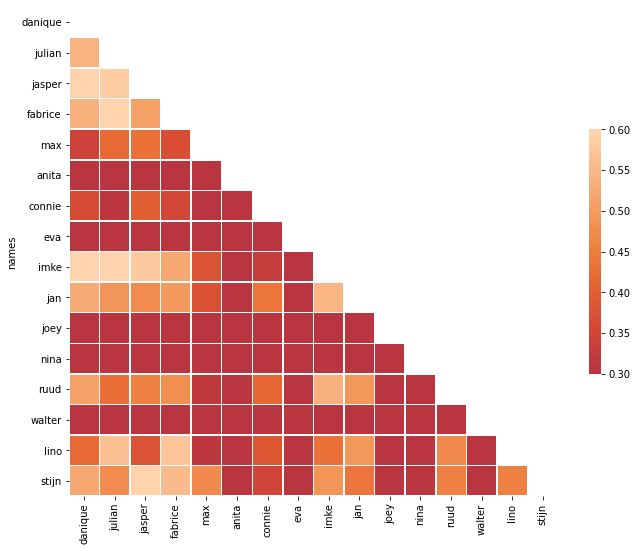

In [37]:
calculate_agreement(result[0], annotators, jaccard_distance)

In [22]:
def powerset(s, min_size):
    '''
    Compute the powerset of the total set of annotators.
    This powerset is a set that contains all possible combinations of annotators.
    It returns only subsets that are consist of at least min_size annotators.
    '''
    powerset = []
    x = len(s)
    for i in range(1 << x):
        powerset.append([s[j] for j in range(x) if (i & (1 << j))])
        
    powerset = [i for i in powerset if len(i) > min_size]
    return powerset

In [26]:
def agreement_measures(annotator_dataframe, annotators):
    '''
    Calculate several agreement measures given a set of annotators.
    '''
    annotations = triples_list(annotator_dataframe, annotators)
        
    annotation_task = AnnotationTask(data = annotations, distance = masi_distance)
    annotation_task_jaccard = AnnotationTask(data=annotations, distance=jaccard_distance)
    
    # Single-metric evaluation of the annotation task
    alpha_masi = annotation_task.alpha()
    alpha_jaccard = annotation_task_jaccard.alpha()
    multi_kappa = annotation_task.multi_kappa()
    
    return alpha_masi, alpha_jaccard, multi_kappa
    
def find_best_team(df, annotators):
    '''
    Collects agreement measures and returns them in a dict
    '''
    if len(annotators)  <= 1:
        return {}
    
    metrics = agreement_measures(df, annotators)
    return {
        'team': annotators,
        'alpha_masi': metrics[0],
        'alpha_jaccard': metrics[1],
        'multi kappa': metrics[2]
    }

In [28]:
# Perform in parallel the experiment where all combinations of annotators are considered
teams =  Parallel(n_jobs = -1, verbose = 1)(delayed(find_best_team)(result[0], team) for team in powerset(annotators,2))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1800 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 5800 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 11400 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 17240 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 21640 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 26840 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 32840 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 39640 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 47240 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 55640 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 64840 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 65399 out of 65399 | elapsed:  6.4min finished


In [29]:
df_results = pd.DataFrame(teams).dropna(subset = ['team']).set_index('team')

In [30]:
df_results = df_results.sort_values(by = 'alpha_jaccard', ascending = False)

In [39]:
df_results.to_pickle('results.pkl')

In [33]:
df_results.sort_values(by='multi kappa', ascending=False)

,alpha_masi,alpha_jaccard,multi kappa
team,,,
"[danique, jasper, imke]",0.595533,0.621290,0.603402
"[danique, julian, jasper, imke]",0.557699,0.589163,0.569237
"[danique, julian, jasper]",0.552332,0.589279,0.567427
"[danique, julian, imke]",0.545781,0.573272,0.555870
"[julian, jasper, imke]",0.536948,0.572464,0.551168
...,...,...,...
"[julian, joey, nina]",0.027135,0.031322,0.066290
"[connie, eva, joey, nina]",0.029363,0.031081,0.063929
"[jan, joey, nina]",0.010803,0.019048,0.060547
